<a href="https://colab.research.google.com/github/ritwiks9635/Image_Captioning/blob/main/Satellite_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🛰Satellite📡Image🛰Captioning📡**

[Dataset🛰🛰🌉🌉](https://www.kaggle.com/datasets/tomtillo/satellite-image-caption-generation)

In [3]:
from IPython.display import clear_output
!pip install vit_keras
!pip install colorama
!pip install tensorflow-addons
clear_output()

In [4]:
import numpy as np
import pandas as pd
from textwrap import wrap
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
from colorama import Fore, Back, Style
import cv2

from vit_keras import vit
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
img_size = 224
batch_size = 32
seed = 10

In [ ]:
df = pd.read_csv("/content/train.csv")

In [ ]:
data_dir = "/content/"
os.listdir(data_dir)

train_data = pd.read_csv("/content/train.csv")
train_data["filepath"] = data_dir + train_data["filepath"]

valid_data = pd.read_csv("/content/valid.csv")
valid_data["filepath"] = data_dir + valid_data["filepath"]

test_data = pd.read_csv("/content/test.csv")
test_data["filepath"] = data_dir + test_data["filepath"]

In [8]:
print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

(8734, 2)
(1093, 2)
(1094, 2)


In [9]:
def text_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("["," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("''"," "))
    data['captions'] = data['captions'].apply(lambda x: x.lower())
    data['captions'] = data['captions'].apply(lambda x: x.replace("[^A-Za-z]"," "))
    data['captions'] = data['captions'].apply(lambda x: x.replace("\s+"," "))
    data['captions'] = data['captions'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    return data

In [10]:
train_data = text_preprocessing(train_data)
valid_data = text_preprocessing(valid_data)
test_data = text_preprocessing(test_data)

In [12]:
txt = train_data["captions"][0]
print(txt)

'many aircraft are parked next to long building in an airport.' 'many planes are parked next to long building at an airport.' 'many planes are parked next to long building in an airport.' 'many planes are parked next to long building at an airport.' 'many planes are parked next to long building in an airport .'


In [13]:
def splitting_captions(df):
    captions_arr = []
    filepaths_arr = []

    for i in range(df.shape[0]):
        img = df['filepath'].values[i]
        captions = re.split(r"' '", df['captions'].values[i])
        for caption in captions:
            captions_arr.append(caption)
            filepaths_arr.append(img)

    data = pd.DataFrame({'captions': captions_arr, 'filepath': filepaths_arr})

    return data

In [14]:
train_data = splitting_captions(train_data)
valid_data = splitting_captions(valid_data)
test_data = splitting_captions(test_data)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(41206, 2)
(5147, 2)
(5203, 2)


In [15]:
def pre_preprocessing(data):
    data['captions'] = data['captions'].apply(lambda x: x.replace("'",""))
    data['captions'] = data['captions'].apply(lambda x: x.replace(".",""))
    data['captions'] = "startseq "+data['captions']+" endseq"

    return data

In [16]:
pre_train_data = pre_preprocessing(train_data)
pre_valid_data = pre_preprocessing(valid_data)
pre_test_data = pre_preprocessing(test_data)

In [18]:
def load_img(img_path, img_size = 224):
    image = keras.utils.load_img(img_path, target_size = (img_size, img_size))
    image = keras.utils.img_to_array(image)
    image = image / 255.0
    return image

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(temp_df["filepath"][i])
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.captions[i], 20)))
        plt.axis("off")

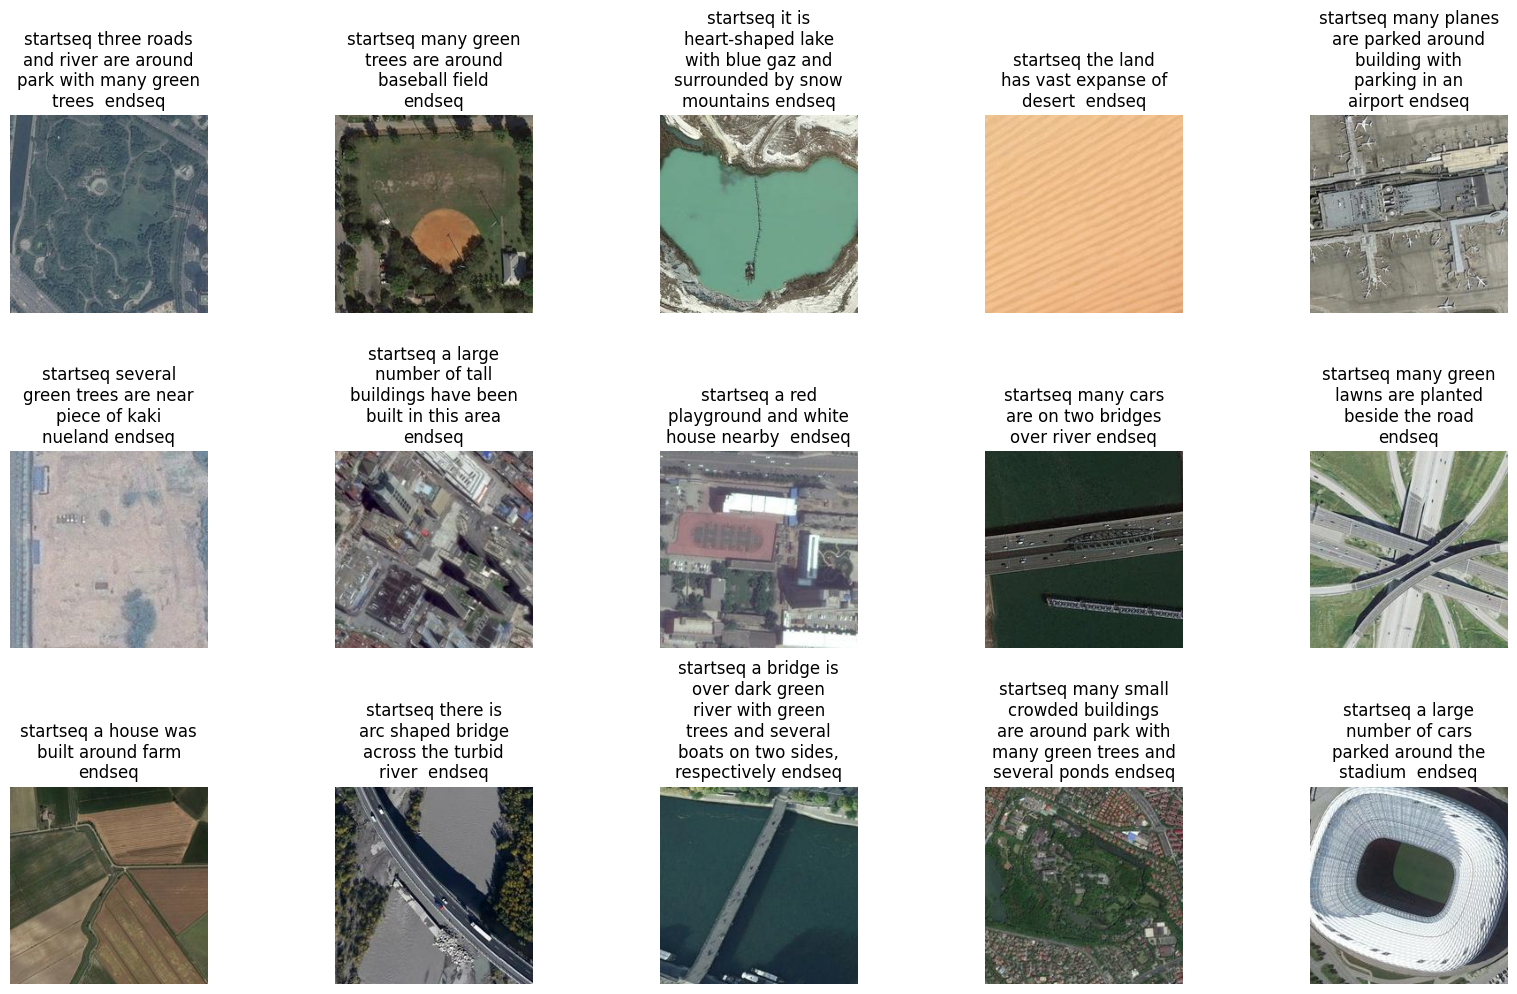

In [19]:
display_images(pre_train_data.sample(15))

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

captions = pre_train_data["captions"].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

train_img = pre_train_data["filepath"].unique().tolist()
train = train_data[train_data["filepath"].isin(train_img)]
train.reset_index(inplace = True, drop = True)

valid_img = pre_valid_data["filepath"].unique().tolist()
valid = valid_data[valid_data["filepath"].isin(valid_img)]
valid.reset_index(inplace = True, drop = True)

test_img = pre_test_data["filepath"].unique().tolist()
test = test_data[test_data["filepath"].isin(test_img)]
test.reset_index(inplace = True, drop = True)

In [21]:
tokenizer.texts_to_sequences([captions[0]])[0]

[1, 5, 189, 3, 48, 49, 20, 120, 36, 10, 26, 55, 2]

In [22]:
tokenizer.sequences_to_texts([[1, 5, 189, 3, 48, 49, 20, 120, 36, 10, 26, 55, 2]])

['startseq many aircraft are parked next to long building in an airport endseq']

In [23]:
vit_model = vit.vit_b16(
    image_size = img_size,
    weights = "imagenet21k+imagenet2012",
    activation = "softmax",
    pretrained = True,
    include_top = True,
    pretrained_top = True,
)
feature_extractor = keras.Model(inputs = vit_model.input, outputs = vit_model.layers[-2].output)

347502902/347502902 [==============================] - 3s 0us/step


In [24]:
def preprocess_image(img_path, captions):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels = 3)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.cast(image, tf.float32) / 255.0
    # 9999 is a null class
    return image, 9999

In [25]:
trainloader = tf.data.Dataset.from_tensor_slices((train['filepath'], train['captions']))
trainloader_features = (trainloader.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
                         .batch(batch_size)
                         .prefetch(tf.data.AUTOTUNE))


validloader = tf.data.Dataset.from_tensor_slices((valid['filepath'], valid['captions']))
validloader_features = (validloader.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
                         .batch(batch_size)
                         .prefetch(tf.data.AUTOTUNE))


testloader = tf.data.Dataset.from_tensor_slices((test['filepath'], test['captions']))
testloader_features = (testloader.map(preprocess_image, num_parallel_calls = tf.data.AUTOTUNE)
                         .batch(batch_size)
                         .prefetch(tf.data.AUTOTUNE))

In [26]:
def create_img_feature_dict(feature_extractor_model, tf_dataset, df):
    img_features = feature_extractor_model.predict(tf_dataset)
    features_dict = {}

    assert df.shape[0] == img_features.shape[0]
    for i in range(df.shape[0]):
        img_feature = tf.expand_dims(img_features[i], axis=0)
        features_dict[df['filepath'].iloc[i]] = img_feature

    return features_dict

In [ ]:
train_img_features = create_img_feature_dict(feature_extractor, trainloader_features, train)
valid_img_features = create_img_feature_dict(feature_extractor, validloader_features, valid)
test_img_features = create_img_feature_dict(feature_extractor, testloader_features, test)

In [30]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [31]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, batch_size, tokenizer, vocab_size, max_length, features, shuffle=True, **kwargs):
        super(CustomDataGenerator, self).__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch['filepath'].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch['filepath']== image, 'captions'].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)


        return X1, X2, y

In [32]:
train_generator = CustomDataGenerator(
    df = pre_train_data,
    batch_size = batch_size,
    tokenizer = tokenizer,
    vocab_size = vocab_size,
    max_length = max_length,
    features = train_img_features,
    shuffle=True)

valid_generator = CustomDataGenerator(
    df = pre_valid_data,
    batch_size = batch_size,
    tokenizer = tokenizer,
    vocab_size = vocab_size,
    max_length = max_length,
    features = valid_img_features,
    shuffle = False)

test_generator = CustomDataGenerator(
    df = pre_test_data,
    batch_size = batch_size,
    tokenizer = tokenizer,
    vocab_size = vocab_size,
    max_length = max_length,
    features = test_img_features,
    shuffle = False)

In [38]:
input1 = keras.Input(shape=(768,))
input2 = keras.Input(shape=(max_length,))

img_features = layers.Dense(512, activation='relu')(input1)
img_features_reshaped = layers.Reshape((1, 512), input_shape=(512,))(img_features)

sentence_features = layers.Embedding(vocab_size, 512, mask_zero=False)(input2)
merged = layers.concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = layers.Bidirectional(layers.LSTM(256, dropout=0.1))(merged)

X = layers.Dropout(0.5)(sentence_features)
X = layers.add([X, img_features])
X = layers.Dense(128, activation='relu')(X)
X = layers.Dropout(0.5)(X)
output = layers.Dense(vocab_size, activation='softmax')(X)

caption_model = keras.Model(inputs=[input1,input2], outputs=output)

In [39]:
caption_model.compile(
    optimizer = keras.optimizers.AdamW(learning_rate = 0.001, weight_decay = 0.004),
    loss = "categorical_crossentropy")

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 512)                  393728    ['input_4[0][0]']             
                                                                                                  
 input_5 (InputLayer)        [(None, 53)]                 0         []                            
                                                                                                  
 reshape_2 (Reshape)         (None, 1, 512)               0         ['dense_1[0][0]']             
                                                                                            

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 2, restore_best_weights = True, min_delta = 0)

history = caption_model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    callbacks = [early_stopping_cb])

In [42]:
caption_model.evaluate(test_generator)

162/162 [==============================] - 23s 144ms/step - loss: 2.9981


2.998136520385742

In [59]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred_ = model.predict([feature,sequence], verbose = 0)
        y_pred = np.argmax(y_pred_)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word
        if word == 'endseq':
            break

    return in_text, y_pred_, y_pred

In [62]:
samples = test.sample(50)
samples.reset_index(drop=True,inplace=True)

# test predictions
for index,record in samples.iterrows():
    image_path = data_dir + '/'

    img = keras.utils.load_img(os.path.join(image_path,record['filepath']),target_size=(224,224))
    img = keras.utils.img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['filepath'], tokenizer, max_length, test_img_features)
    samples.loc[index,'captions'] = caption

In [64]:
def display_prediction_images(temp_df, SEED):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (5,5))

    idx = np.random.default_rng(seed=SEED).permutation(temp_df.shape[0])[0]
    img = cv2.imread(temp_df.iloc[idx]['filepath'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_captions = test.loc[test['filepath']== temp_df.filepath[idx], 'captions'].tolist()[:3]

    pred_caption = temp_df.iloc[idx]['captions'][0]
    pred_caption = pred_caption.replace('startseq ', ' ')
    pred_caption = pred_caption.replace(' endseq', ' ')


    for true_caption in true_captions:
        true_caption = true_caption.replace('startseq ', ' ')
        true_caption = true_caption.replace(' endseq', ' ')
        print(Fore.GREEN + "TRUE : " +true_caption + '\n')


    print(Fore.RED + "PRED : "+ pred_caption)


    plt.imshow(img)
    plt.axis('off')

TRUE :  near the beach there is building at high elevation and some houses in the resort 

TRUE :  near the beach there is high rise building and some houses in the resort  

TRUE :  the orange resort is betweeen beach and street  

PRED :  many green trees and several buildings are in resort with swimming pool 


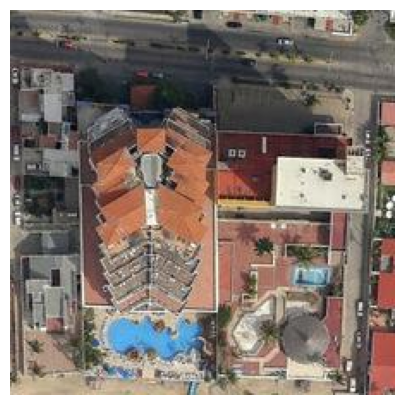

In [69]:
display_prediction_images(samples, 9)

TRUE :  a church with red brick roofs and regular blue green octagonal pyramidal roof is located close to parking lot and sports grounds 

TRUE :  a church with pitched brick red roofs and regular octagon pyramidal roof of blue green is located near parking lot and sports field  

TRUE :  the red pliers shape church with cyan octagon roof is surrounded by some trees  

PRED :  a church is surrounded by many green trees 


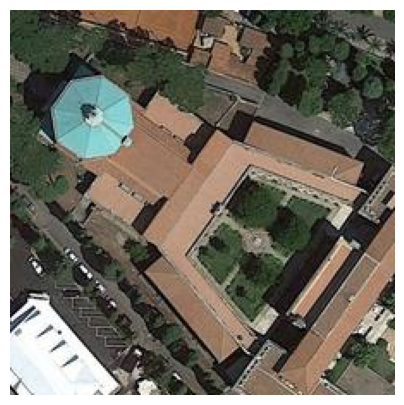

In [74]:
display_prediction_images(samples, 25)

TRUE :  among the forest four houses with three swimming pools built on the coast 

TRUE :  between the forest four houses with three swimming pools built on the coast 

TRUE :  among forest four houses with three swimming pools built on the coast  

PRED :  many green trees and some buildings are in resort with swimming pool 


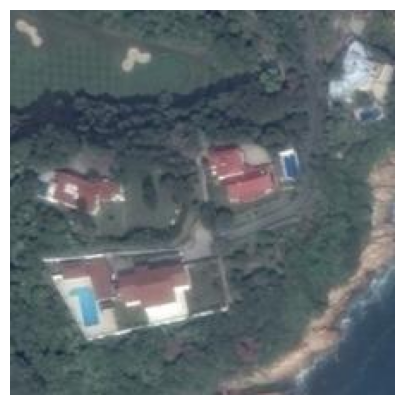

In [76]:
display_prediction_images(samples, 90)